In [2]:
from photutils.segmentation import make_source_mask
import numpy as np
import scipy.optimize as opt
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch
import matplotlib.pyplot as plt
plt.style.use(astropy_mpl_style)

In [3]:
# Opening the images and averaging the calibration frames
hdul = fits.open('image3.fit')
hdul.info()

img = fits.getdata('image3.fit')
bias = fits.getdata('bias.fit')
dark = fits.getdata('dark.fit')
flat = fits.getdata('flat.fit')

from fonctions import *
bias = averageFolder('bias')
dark = averageFolder('dark')
flat = averageFolder('flat')

Filename: image3.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (6248, 4176)   int16 (rescales to uint16)   


/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_43974/2795002898.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ca = plt.colorbar()


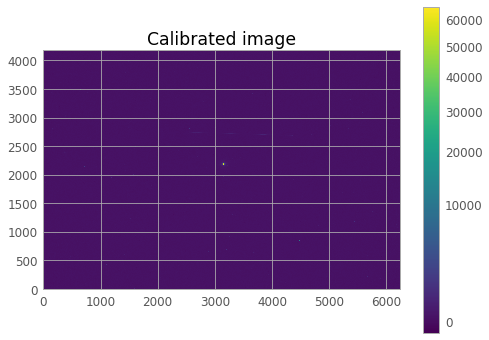

In [4]:
# Image calibrated using the different average calibration frames
#from fonctions import *
image_clean = calibrate(img, bias, dark, flat)
#image_clean = image_clean - np.min(image_clean)
#image_clean = image_clean / np.max(image_clean) * (2**16-1)
plt.figure()
plt.title('Calibrated image')
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(image_clean, norm=norm, origin='lower', cmap='viridis', interpolation='none')
ca = plt.colorbar()
plt.show()

/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_43974/2870739149.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


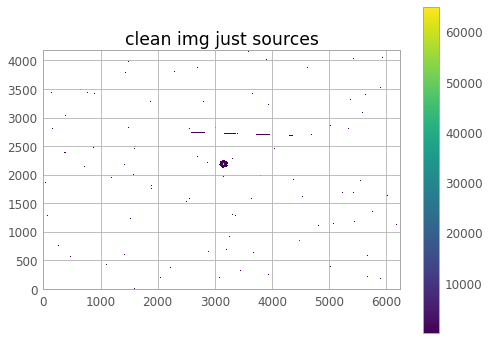

In [5]:
# Masking sources
mask = make_source_mask(image_clean, nsigma=5, npixels=20, dilate_size=1)

# Showing the sources
plt.figure()
plt.title('clean img just sources')
#inverted_masked_image = np.ma.masked_where(np.logical_not(mask), image_clean)
inverted_masked_image = np.ma.array(image_clean, mask=np.logical_not(mask), fill_value=np.NaN)

plt.imshow(inverted_masked_image, origin='lower',
           cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

True


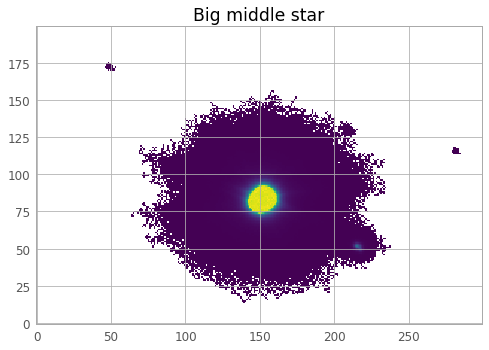

In [6]:
outcut = inverted_masked_image[2100:2300, 3000:3300]
print(np.isnan(outcut.filled()[0:100, 0:100]).any())
#outcut = inverted_masked_image[0:10, 2500:3500]
plt.figure()
plt.title('Big middle star')
plt.imshow(outcut, origin='lower', cmap='viridis', interpolation='none')
#plt.colorbar()
plt.show()

True


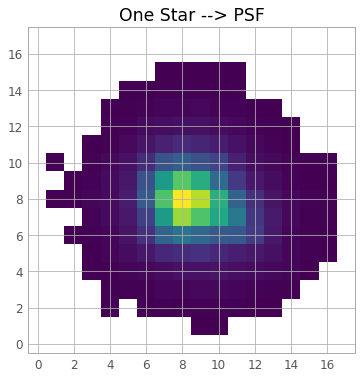

In [97]:
outcut = inverted_masked_image[575:593, 5649:5667]
print(np.isnan(outcut.filled()[0:100, 0:100]).any())
#outcut = inverted_masked_image[0:10, 2500:3500]
plt.figure()
plt.title('One Star --> PSF')
plt.imshow(outcut, origin='lower', cmap='viridis', interpolation='none')
#plt.colorbar()
plt.show()


In [7]:
# Searching the position of all stars
i = 10
list_of_coordinates = []
inverted_masked_image_filled = inverted_masked_image.filled()
while i < (np.shape(mask)[0]-11):
    j = 10
    while j < (np.shape(mask)[1]-11):
        found_something = False
        # and not (i > 2110 and i < 2260 and j > 3060 and j < 3240)
        if not (np.isnan(inverted_masked_image_filled[i-5:i+5, j-5:j+5])).any() and (i < 2110 or i > 2260 or j < 3060 or j > 3240):
            found_something = True
            list_of_coordinates.append((i, j))
            j += 20
            #print(inverted_masked_image[i:i+10, j:j+10])
        else:
            j += 1
    if found_something:
        i += 10
    else:
        i += 1
print(len(list_of_coordinates))

94


(3488, 650)


/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_43974/3525446740.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_43974/3525446740.py:28: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xs, ys, interpolated_data.reshape(np.shape(outcut)), 10, colors='w', label='test')


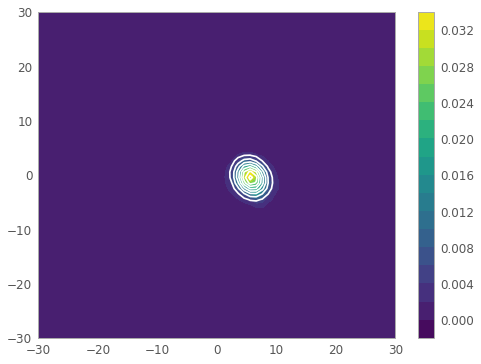

In [12]:
# Test to see if random star is well found
coords = list_of_coordinates[85]
print(coords)

i_begin = np.max([0, coords[0]-30])
i_end = np.min([np.shape(img)[0], coords[0]+30])
j_begin = np.max([0, coords[1]-30])
j_end = np.min([np.shape(img)[1], coords[1]+30])

outcut = image_clean[i_begin:i_end, j_begin:j_end]
outcut = outcut/np.sum(outcut)

initial_guess = (0, 0, 1, 1, 0.1, 0)
lim_i = (i_end - i_begin)/2
lim_j = (j_end - j_begin)/2
xs = np.linspace(-lim_i, lim_i, np.shape(outcut)[1])
ys = np.linspace(-lim_j, lim_j, np.shape(outcut)[0])
xy = np.meshgrid(xs, ys)
xy = np.ravel(xy)
params, covar = opt.curve_fit(
    gaussian2D, xy, np.ravel(outcut), p0=initial_guess)
interpolated_data = gaussian2D(xy, params[0], params[1],
                               params[2], params[3], params[4], params[5])

plt.figure()
plt.contourf(xs, ys, outcut, 20, origin='lower', cmap='viridis')
plt.colorbar()
plt.contour(xs, ys, interpolated_data.reshape(np.shape(outcut)), 10, colors='w', label='test')


In [ ]:
from fonctions import *

parameters = []

for coords in list_of_coordinates[:5500]:
    i_begin = np.max([0, coords[0]-20])
    i_end = np.min([np.shape(img)[0], coords[0]+20])
    j_begin = np.max([0, coords[1]-20])
    j_end = np.min([np.shape(img)[1], coords[1]+20])
    
    outcut = image_clean[i_begin:i_end, j_begin:j_end]
    outcut = outcut/np.sum(outcut)

    initial_guess = (0, 0, 1, 1, 0.1, 0)
    lim_i = (i_end - i_begin)/2
    lim_j = (j_end - j_begin)/2
    xs = np.linspace(-lim_i, lim_i, np.shape(outcut)[1])
    ys = np.linspace(-lim_j, lim_j, np.shape(outcut)[0])
    xy = np.meshgrid(xs, ys)
    xy = np.ravel(xy)
    try:
        params, _ = opt.curve_fit(gaussian2D, xy, np.ravel(outcut), p0=initial_guess)
    except RuntimeError:
        params = [0,0,0,0,0]
    parameters.append(params)
    #interpolated_data = gaussian2D(xy, params[0], params[1], params[2], params[3], params[4], params[5])

In [ ]:
# Test that automatic fitting worked
N = 134
params = parameters[N]
coords = list_of_coordinates[N]
print(coords)

i_begin = np.max([0, coords[0]-20])
i_end = np.min([np.shape(img)[0], coords[0]+20])
j_begin = np.max([0, coords[1]-20])
j_end = np.min([np.shape(img)[1], coords[1]+20])

outcut = image_clean[i_begin:i_end, j_begin:j_end]
outcut = outcut/np.sum(outcut)

lim_i = (i_end - i_begin)/2
lim_j = (j_end - j_begin)/2
xs = np.linspace(-lim_i, lim_i, np.shape(outcut)[1])
ys = np.linspace(-lim_j, lim_j, np.shape(outcut)[0])
xy = np.meshgrid(xs, ys)
xy = np.ravel(xy)


interpolated_data = gaussian2D(xy, params[0], params[1], params[2], params[3], params[4], params[5])
plt.figure()
plt.contourf(xs, ys, outcut, 20, origin='lower', cmap='viridis')
plt.colorbar()
plt.contour(xs, ys, interpolated_data.reshape(
    np.shape(outcut)), 10, colors='w', label='test')


In [ ]:
for coords in list_of_coordinates[5501:]:
    i_begin = np.max([0, coords[0]-20])
    i_end = np.min([np.shape(img)[0], coords[0]+20])
    j_begin = np.max([0, coords[1]-20])
    j_end = np.min([np.shape(img)[1], coords[1]+20])
    
    outcut = image_clean[i_begin:i_end, j_begin:j_end]
    outcut = outcut/np.sum(outcut)

    initial_guess = (0, 0, 1, 1, 0.1, 0)
    xs = np.linspace(-5, 5, np.shape(outcut)[1])
    ys = np.linspace(-5, 5, np.shape(outcut)[0])
    xy = np.meshgrid(xs, ys)
    xy = np.ravel(xy)
    try:
        params, _ = opt.curve_fit(gaussian2D, xy, np.ravel(outcut), p0=initial_guess)
    except RuntimeError:
        params = [0,0,0,0,0]
    parameters.append(params)
    #interpolated_data = gaussian2D(xy, params[0], params[1], params[2], params[3], params[4], params[5])

In [ ]:
sigma_x_map = np.zeros(np.shape(image_clean))
sigma_y_map = np.zeros(np.shape(image_clean))
theta_map = np.zeros(np.shape(image_clean))

for i in range(len(parameters)):
    coords = list_of_coordinates[i]
    i_begin = np.max([0, coords[0]-20])
    i_end = np.min([np.shape(img)[0], coords[0]+20])
    j_begin = np.max([0, coords[1]-20])
    j_end = np.min([np.shape(img)[1], coords[1]+20])
    sigma_x_map[i_begin:i_end, j_begin:j_end] = parameters[i][2]
    sigma_y_map[i_begin:i_end, j_begin:j_end] = parameters[i][3]
    theta_map[i_begin:i_end, j_begin:j_end] = parameters[i][4]

plt.figure()
plt.title(r'$\sigma_x$')
plt.imshow(np.log(np.abs(sigma_x_map)), origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title(r'$\sigma_y$')
plt.imshow(np.log(np.abs(sigma_y_map)), origin='lower',
           cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title(r'$\theta$')
plt.imshow(np.log(theta_map*180/np.pi), origin='lower',
           cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()
